In [1]:
import pandas as pd

In [2]:
from google.colab import files
df = files.upload()

Saving FinalFleet_Data.csv to FinalFleet_Data.csv


In [3]:
df = pd.read_csv("FinalFleet_Data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0.1               1091 non-null   int64  
 1   Unnamed: 0                 727 non-null    float64
 2   Equipment Number           1091 non-null   object 
 3   Equipment Class            1091 non-null   object 
 4   Equipment Category         1091 non-null   object 
 5   Service Group              1091 non-null   object 
 6   Department                 1091 non-null   object 
 7   Make                       1091 non-null   object 
 8   Model                      1091 non-null   object 
 9   Year                       1091 non-null   int64  
 10  Site                       1091 non-null   object 
 11  Mileage2024 (km)           833 non-null    float64
 12  HourMeter2024 (hours)      332 non-null    float64
 13  DowntimeHours2024 (hours)  1091 non-null   float

In [5]:
df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)

#Total Co2 emission in 2024

In [6]:
total_Co2_2024 = df["Total CO2 Emission (g)"].sum()
total_Co2_2024

np.float64(14001543209.21993)

In [7]:
total_Co2_2024/1000000000  #14 kilotonnes

np.float64(14.00154320921993)

In [8]:
target_Co2_2027 = total_Co2_2024 * 0.8
target_Co2_2027

np.float64(11201234567.375946)

In [9]:
target_Co2_2027/1000000000  #11 kilotonnes

np.float64(11.201234567375947)

# 3 killotonnes reduction is required

#So, aim is to reduce total Co2 to 11 kilotonnes

##Since CO₂ rate is standard and not influenced by operational inefficiency, and age has no correlation with inefficiency or usage, it makes perfect sense that no correlation exists between CO2 rate and inefficiency metrics.



---

To help the City of Vancouver meet its CO₂ emission reduction target, we recommend prioritizing the removal of vehicles that show high operational inefficiency.

Our analysis reveals significant outliers in both Labor Hours and Downtime Hours, indicating certain vehicles require excessive maintenance or are frequently unavailable — clear signs of poor performance.


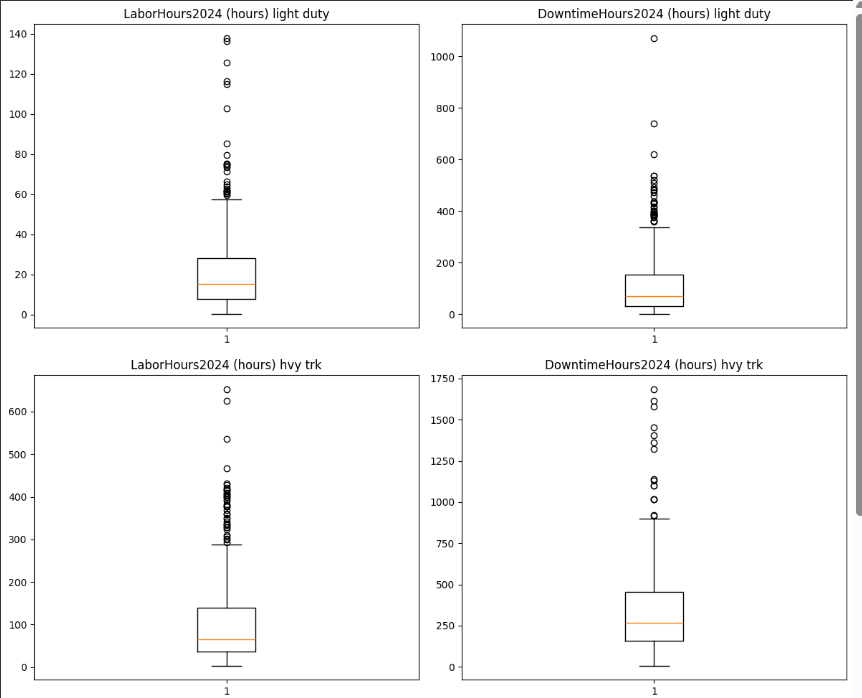

#Therefore, we will calculate the prioritization score, which comprises the CO2 rate, labor hours, and downtime

#Stakeholder communication simulation

*  The City of Vancouver’s primary goal is to reduce fleet-related CO₂ emissions.

*   Therefore, 60% of the weight is allocated to the CO₂ Rate, which reflects the inherent emission intensity of each vehicle class (as per standardized values from Environment Canada).

*   However, the City has also expressed interest in removing inefficient vehicles that increase operational cost and downtime.

*   Thus, the remaining 40% of the weight is assigned to an inefficiency score, split evenly between labour hours and downtime.

*   This approach ensures that vehicles with both high environmental and operational burdens are prioritized for removal, supporting the City’s climate and efficiency objectives simultaneously.








#Lets calculate prioritization score for light duty

In [10]:
df["Equipment Category"].unique()

array(['light duty', 'hvy trk', 'hvy equip'], dtype=object)

In [11]:
df_light_duty = df[df["Equipment Category"] == "light duty"].copy()

#we need to normalize the metrics first in order to apply proportional weight

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_light_duty[["Nor_downtime", "Nor_laborhours", "Nor_Co2(g/km)"]] = scaler.fit_transform(df_light_duty[["DowntimeHours2024 (hours)", "LaborHours2024 (hours)", "CO2(g/km)"]])

In [13]:
df_light_duty.head()

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),...,DowntimeHours2024 (hours),LaborHours2024 (hours),PrimaryMetric,Age,CO2(g/km),Total CO2 Emission (g),CO2(g/hour),Nor_downtime,Nor_laborhours,Nor_Co2(g/km)
0,A0006,"VAN, MINI, 7 PASSENGER",light duty,Engineering Services,ENGINEERING EQUIPMENT CAR SHARE,FORD,WINDSTAR,2003,CROSSROADS (507 W. BROADWAY),6040.0,...,740.432781,102.75251,mileage,22,272.782631,1.647607e+06,NaN,0.690539,0.744561,1.0
1,A0131,"AUTO, PASSENGER, MICRO COMPACT",light duty,Engineering Services,ENGINEERING EQUIPMENT CAR SHARE,MERCEDES,SMARTC,2008,CROSSROADS (507 W. BROADWAY),3485.0,...,412.597220,54.35750,mileage,17,272.782631,9.506475e+05,NaN,0.384278,0.393269,1.0
2,A0149,"AUTO, PASSENGER, COMPACT WAGON",light duty,Engineering Services,ENGINEERING STREETS OPER.,FORD,FOCUS,2006,NATIONAL YD. (701 NATIONAL),14379.0,...,89.826946,15.17277,mileage,19,272.782631,3.922341e+06,NaN,0.082748,0.108832,1.0
3,A0152,"AUTO, PASSENGER, COMPACT WAGON",light duty,Engineering Services,ENGINEERING TRAFF & ELEC SRVCS,FORD,FOCUS,2008,NATIONAL YD. (701 NATIONAL),11908.0,...,8.823056,6.12665,mileage,17,272.782631,3.248296e+06,NaN,0.007075,0.043168,1.0
4,A0153,"AUTO, PASSENGER, COMPACT",light duty,Engineering Services,ENGINEERING PROJECTS,FORD,FOCUS,2008,CROSSROADS (507 W. BROADWAY),8114.0,...,20.933889,7.35584,mileage,17,272.782631,2.213358e+06,NaN,0.018389,0.052090,1.0


In [14]:
df_light_duty["Priority Score"] = 0.6 * df_light_duty['Nor_Co2(g/km)'] + 0.2 * df_light_duty["Nor_downtime"] + 0.2 * df_light_duty["Nor_laborhours"]

In [15]:
df_light_duty["Priority rank"] = df_light_duty['Priority Score'].rank(method="dense", ascending=False).astype(int)

In [16]:
df_light_duty.head()

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),...,PrimaryMetric,Age,CO2(g/km),Total CO2 Emission (g),CO2(g/hour),Nor_downtime,Nor_laborhours,Nor_Co2(g/km),Priority Score,Priority rank
0,A0006,"VAN, MINI, 7 PASSENGER",light duty,Engineering Services,ENGINEERING EQUIPMENT CAR SHARE,FORD,WINDSTAR,2003,CROSSROADS (507 W. BROADWAY),6040.0,...,mileage,22,272.782631,1.647607e+06,NaN,0.690539,0.744561,1.0,0.887020,3
1,A0131,"AUTO, PASSENGER, MICRO COMPACT",light duty,Engineering Services,ENGINEERING EQUIPMENT CAR SHARE,MERCEDES,SMARTC,2008,CROSSROADS (507 W. BROADWAY),3485.0,...,mileage,17,272.782631,9.506475e+05,NaN,0.384278,0.393269,1.0,0.755509,13
2,A0149,"AUTO, PASSENGER, COMPACT WAGON",light duty,Engineering Services,ENGINEERING STREETS OPER.,FORD,FOCUS,2006,NATIONAL YD. (701 NATIONAL),14379.0,...,mileage,19,272.782631,3.922341e+06,NaN,0.082748,0.108832,1.0,0.638316,198
3,A0152,"AUTO, PASSENGER, COMPACT WAGON",light duty,Engineering Services,ENGINEERING TRAFF & ELEC SRVCS,FORD,FOCUS,2008,NATIONAL YD. (701 NATIONAL),11908.0,...,mileage,17,272.782631,3.248296e+06,NaN,0.007075,0.043168,1.0,0.610049,335
4,A0153,"AUTO, PASSENGER, COMPACT",light duty,Engineering Services,ENGINEERING PROJECTS,FORD,FOCUS,2008,CROSSROADS (507 W. BROADWAY),8114.0,...,mileage,17,272.782631,2.213358e+06,NaN,0.018389,0.052090,1.0,0.614096,314


#Lets calculate prioritization score for heavy trucks.

In [17]:
df["Equipment Category"].unique()

array(['light duty', 'hvy trk', 'hvy equip'], dtype=object)

In [18]:
df_heavy = df[df["Equipment Category"] == "hvy trk"].copy()

#For fleets measured in mileage

In [19]:
df_heavy_mileage = df_heavy[df_heavy["PrimaryMetric"] == "mileage"].copy()

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_heavy_mileage[["Nor_downtime", "Nor_laborhours", "Nor_Co2(g/km)"]] = scaler.fit_transform(df_heavy_mileage[["DowntimeHours2024 (hours)", "LaborHours2024 (hours)", "CO2(g/km)"]])

In [21]:
df_heavy_mileage.head()

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),...,DowntimeHours2024 (hours),LaborHours2024 (hours),PrimaryMetric,Age,CO2(g/km),Total CO2 Emission (g),CO2(g/hour),Nor_downtime,Nor_laborhours,Nor_Co2(g/km)
505,A1203,"TRUCK, DUMP, 1 YARD",hvy trk,Engineering Services,ENGINEERING STREETS OPER.,FORD,F450,2008,NATIONAL YD. (701 NATIONAL),19194.0,...,437.383329,125.26611,mileage,17,1808.194664,3.470649e+07,NaN,0.257255,0.288323,0.308917
506,A1204,"TRUCK, DUMP, 1 YARD",hvy trk,Engineering Services,ENGINEERING STREETS OPER.,FORD,F550,2006,NATIONAL YD. (701 NATIONAL),3088.0,...,200.696388,47.08251,mileage,19,1808.194664,5.583705e+06,NaN,0.116445,0.104130,0.308917
507,A1205,"TRUCK, DUMP, 1 YARD",hvy trk,Engineering Services,ENGINEERING EQS LOANER POOL,FORD,F450,2007,NATIONAL YD. (701 NATIONAL),5155.0,...,40.551945,18.69334,mileage,18,1808.194664,9.321243e+06,NaN,0.021171,0.037249,0.308917
508,A1206,"TRUCK, VAN, POWER TAILGATE, SINGLE AXLE",hvy trk,Engineering Services,ENGINEERING STREETS OPER.,FORD,F350,2003,MANITOBA YD. (250 W. 70TH),4396.0,...,94.964444,10.56415,mileage,22,2140.902482,9.411407e+06,NaN,0.053542,0.018097,0.593121
509,A1240,"TRUCK, DUMP, 1 YARD",hvy trk,Engineering Services,ENGINEERING STREETS OPER.,FORD,F550,2005,NATIONAL YD. (701 NATIONAL),3998.0,...,257.955280,70.89446,mileage,20,1808.194664,7.229162e+06,NaN,0.150509,0.160229,0.308917


In [22]:
df_heavy_mileage["Priority Score"] = 0.6 * df_heavy_mileage['Nor_Co2(g/km)'] + 0.2 * df_heavy_mileage["Nor_downtime"] + 0.2 * df_heavy_mileage["Nor_laborhours"]

In [23]:
df_heavy_mileage["Priority rank"] = df_heavy_mileage['Priority Score'].rank(method="dense", ascending=False).astype(int)

In [24]:
df_heavy_mileage.head()

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),...,PrimaryMetric,Age,CO2(g/km),Total CO2 Emission (g),CO2(g/hour),Nor_downtime,Nor_laborhours,Nor_Co2(g/km),Priority Score,Priority rank
505,A1203,"TRUCK, DUMP, 1 YARD",hvy trk,Engineering Services,ENGINEERING STREETS OPER.,FORD,F450,2008,NATIONAL YD. (701 NATIONAL),19194.0,...,mileage,17,1808.194664,3.470649e+07,NaN,0.257255,0.288323,0.308917,0.294466,175
506,A1204,"TRUCK, DUMP, 1 YARD",hvy trk,Engineering Services,ENGINEERING STREETS OPER.,FORD,F550,2006,NATIONAL YD. (701 NATIONAL),3088.0,...,mileage,19,1808.194664,5.583705e+06,NaN,0.116445,0.104130,0.308917,0.229465,230
507,A1205,"TRUCK, DUMP, 1 YARD",hvy trk,Engineering Services,ENGINEERING EQS LOANER POOL,FORD,F450,2007,NATIONAL YD. (701 NATIONAL),5155.0,...,mileage,18,1808.194664,9.321243e+06,NaN,0.021171,0.037249,0.308917,0.197034,281
508,A1206,"TRUCK, VAN, POWER TAILGATE, SINGLE AXLE",hvy trk,Engineering Services,ENGINEERING STREETS OPER.,FORD,F350,2003,MANITOBA YD. (250 W. 70TH),4396.0,...,mileage,22,2140.902482,9.411407e+06,NaN,0.053542,0.018097,0.593121,0.370201,163
509,A1240,"TRUCK, DUMP, 1 YARD",hvy trk,Engineering Services,ENGINEERING STREETS OPER.,FORD,F550,2005,NATIONAL YD. (701 NATIONAL),3998.0,...,mileage,20,1808.194664,7.229162e+06,NaN,0.150509,0.160229,0.308917,0.247498,204


#For fleets measured in hoursmeter

In [25]:
df_heavy_hours = df_heavy[df_heavy["PrimaryMetric"] != "mileage"].copy()

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_heavy_hours[["Nor_downtime", "Nor_laborhours", "Nor_CO2(g/hour)"]] = scaler.fit_transform(df_heavy_hours[["DowntimeHours2024 (hours)", "LaborHours2024 (hours)", "CO2(g/hour)"]])

In [27]:
df_heavy_hours.head()

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),...,DowntimeHours2024 (hours),LaborHours2024 (hours),PrimaryMetric,Age,CO2(g/km),Total CO2 Emission (g),CO2(g/hour),Nor_downtime,Nor_laborhours,Nor_CO2(g/hour)
833,C1572,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,471.970273,217.64138,hours,20,NaN,123129500.0,123500.0,0.324192,0.307785,1.0
834,C1573,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,708.491949,467.32168,hours,20,NaN,230698000.0,123500.0,0.512298,0.704879,1.0
835,C1574,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,507.568055,310.14176,hours,20,NaN,177840000.0,123500.0,0.352503,0.454899,1.0
836,C1575,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,700.797787,431.43499,hours,20,NaN,146841500.0,123500.0,0.506179,0.647804,1.0
837,C1576,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,469.196114,269.46219,hours,20,NaN,154745500.0,123500.0,0.321986,0.390201,1.0


In [28]:
df_heavy_hours["Priority Score"] = 0.6 * df_heavy_hours['Nor_CO2(g/hour)'] + 0.2 * df_heavy_hours["Nor_downtime"] + 0.2 * df_heavy_hours["Nor_laborhours"]

In [29]:
df_heavy_hours

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),...,LaborHours2024 (hours),PrimaryMetric,Age,CO2(g/km),Total CO2 Emission (g),CO2(g/hour),Nor_downtime,Nor_laborhours,Nor_CO2(g/hour),Priority Score
833,C1572,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,217.64138,hours,20,NaN,123129500.0,123500.0,0.324192,0.307785,1.0,0.726395
834,C1573,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,467.32168,hours,20,NaN,230698000.0,123500.0,0.512298,0.704879,1.0,0.843435
835,C1574,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,310.14176,hours,20,NaN,177840000.0,123500.0,0.352503,0.454899,1.0,0.761480
836,C1575,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,431.43499,hours,20,NaN,146841500.0,123500.0,0.506179,0.647804,1.0,0.830797
837,C1576,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,269.46219,hours,20,NaN,154745500.0,123500.0,0.321986,0.390201,1.0,0.742437
838,C1577,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,404.07636,hours,20,NaN,150423000.0,123500.0,0.366386,0.604293,1.0,0.794136
839,C1578,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,536.16336,hours,20,NaN,200564000.0,123500.0,0.569544,0.814365,1.0,0.876782
840,C1579,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,421.41748,hours,20,NaN,147706000.0,123500.0,0.649100,0.631872,1.0,0.856195
841,C1580,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,323.33897,hours,20,NaN,163143500.0,123500.0,0.324803,0.475888,1.0,0.760138
842,C1581,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,306.95614,hours,20,NaN,162773000.0,123500.0,0.389370,0.449832,1.0,0.767840


In [30]:
df_heavy_hours["Priority rank"] = df_heavy_hours['Priority Score'].rank(method="dense", ascending=False).astype(int)

In [31]:
df_heavy_hours.head()

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),...,PrimaryMetric,Age,CO2(g/km),Total CO2 Emission (g),CO2(g/hour),Nor_downtime,Nor_laborhours,Nor_CO2(g/hour),Priority Score,Priority rank
833,C1572,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,hours,20,NaN,123129500.0,123500.0,0.324192,0.307785,1.0,0.726395,27
834,C1573,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,hours,20,NaN,230698000.0,123500.0,0.512298,0.704879,1.0,0.843435,8
835,C1574,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,hours,20,NaN,177840000.0,123500.0,0.352503,0.454899,1.0,0.761480,22
836,C1575,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,hours,20,NaN,146841500.0,123500.0,0.506179,0.647804,1.0,0.830797,11
837,C1576,"TRUCK, REFUSE, SIDE LOADER, AUTOMATED, 20 YARD",hvy trk,Engineering Services,ENGINEERING SANITATION UTILITY,STERLING,CONDOR,2005,MANITOBA YD. (250 W. 70TH),NaN,...,hours,20,NaN,154745500.0,123500.0,0.321986,0.390201,1.0,0.742437,25


In [32]:
len(df_heavy_hours)

36

Why Not Combine All Fleets into One Priority Score?
Because different equipment categories (like light-duty and heavy trucks) operate on very different scales, combining them into a single normalized model introduces bias.
A light-duty vehicle with relatively low emissions might look “worse” than a heavy truck simply because its peers are more efficient.

#Multiple Startegies to achieve co2 emission target.

In [33]:
df_CO2_redu_LT = df_light_duty.sort_values(by="Priority Score", ascending=False).head(75)

In [34]:
(df_CO2_redu_LT["Total CO2 Emission (g)"].sum())/1000000000

np.float64(0.2491629289025315)

In [35]:
df_CO2_redu_HT_mileage = df_heavy_mileage.sort_values(by="Priority Score", ascending=False).head(37)

In [36]:
(df_CO2_redu_HT_mileage["Total CO2 Emission (g)"].sum())/1000000000

np.float64(2.2723452371779738)

In [37]:
df_CO2_redu_HT_hours = df_heavy_hours.sort_values(by="Priority Score", ascending=False).head(3)

In [38]:
(df_CO2_redu_HT_hours["Total CO2 Emission (g)"].sum())/1000000000

np.float64(0.5168475)

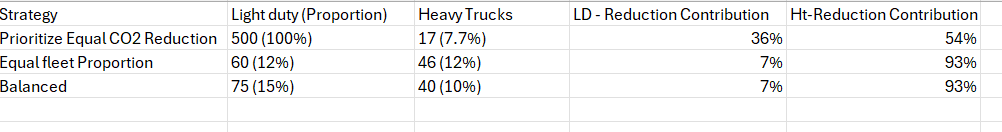

#Business Communication simulation:



As per the simulated communication with stakeholders, it was conveyed that the light-duty fleet can only reduce services by a maximum of 15%. Based on this constraint, we developed a balanced reduction strategy that honors this limit while still progressing toward the CO₂ emission reduction target.

This strategy carefully distributes the burden between light-duty and heavy-truck categories, ensuring practical feasibility while maintaining emissions impact.

In [39]:
df_planedremoval_fleets = pd.concat([df_CO2_redu_LT, df_CO2_redu_HT_mileage, df_CO2_redu_HT_hours], axis=0)

In [40]:
df_planedremoval_fleets["Department"].value_counts()

,count
Department,
ENGINEERING SANITATION OPER.,18
ENGINEERING SEWERS OPER.,16
ENGINEERING STREETS OPER.,12
ENGINEERING TRANSFER AND LANDFILL OPER.,11
ENGINEERING SANITATION UTILITY,10
ENGINEERING TRAFF & ELEC SRVCS,8
ENGINEERING PARKING OPERATIONS ENFORCEMENT,5
ENGINEERING EQUIPMENT CAR SHARE,5
REAL ESTATE & FACILITIES MANAGEMENT,5


In [41]:
df_planedremoval_fleets.head()

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),...,Age,CO2(g/km),Total CO2 Emission (g),CO2(g/hour),Nor_downtime,Nor_laborhours,Nor_Co2(g/km),Priority Score,Priority rank,Nor_CO2(g/hour)
479,D1535,"VAN, 1.5TON, CUBE BODY",light duty,Engineering Services,ENGINEERING SANITATION OPER.,FORD,E450,2005,MANITOBA YD. (250 W. 70TH),15831.0,...,20,272.782631,4.318422e+06,NaN,1.000000,0.842069,1.0,0.968414,1,NaN
455,C1371,"VAN, 1.5TON, CUBE BODY",light duty,Engineering Services,ENGINEERING SEWERS OPER.,FORD,E450,2004,MANITOBA YD. (250 W. 70TH),20985.0,...,21,272.782631,5.724344e+06,NaN,0.474637,0.987591,1.0,0.892446,2,NaN
0,A0006,"VAN, MINI, 7 PASSENGER",light duty,Engineering Services,ENGINEERING EQUIPMENT CAR SHARE,FORD,WINDSTAR,2003,CROSSROADS (507 W. BROADWAY),6040.0,...,22,272.782631,1.647607e+06,NaN,0.690539,0.744561,1.0,0.887020,3,NaN
440,B1934,"VAN, 1TON, CUBE BODY",light duty,Engineering Services,ENGINEERING EQUIPMENT OPER.,FORD,E350,2006,MANITOBA YD. (250 W. 70TH),2666.0,...,19,272.782631,7.272385e+05,NaN,0.358590,1.000000,1.0,0.871718,4,NaN
457,C1842,"TRUCK, REFUSE, LITTER PICKUP",light duty,Engineering Services,ENGINEERING SANITATION OPER.,FORD,RANGER,2009,MANITOBA YD. (250 W. 70TH),8640.0,...,16,272.782631,2.356842e+06,NaN,0.354311,0.911787,1.0,0.853220,5,NaN


In [42]:
df_planedremoval_fleets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115 entries, 479 to 839
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Equipment Number           115 non-null    object 
 1   Equipment Class            115 non-null    object 
 2   Equipment Category         115 non-null    object 
 3   Service Group              115 non-null    object 
 4   Department                 115 non-null    object 
 5   Make                       115 non-null    object 
 6   Model                      115 non-null    object 
 7   Year                       115 non-null    int64  
 8   Site                       115 non-null    object 
 9   Mileage2024 (km)           112 non-null    float64
 10  HourMeter2024 (hours)      6 non-null      float64
 11  DowntimeHours2024 (hours)  115 non-null    float64
 12  LaborHours2024 (hours)     115 non-null    float64
 13  PrimaryMetric              115 non-null    object 
 1

#lets combine all the fleets

## We need heavy equip records as well for the powerbi dashboard.

In [43]:
df_heavy_Equip = df[df["Equipment Category"] == "hvy equip"].copy()

In [44]:
df_heavy_Equip.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, 869 to 1090
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Equipment Number           222 non-null    object 
 1   Equipment Class            222 non-null    object 
 2   Equipment Category         222 non-null    object 
 3   Service Group              222 non-null    object 
 4   Department                 222 non-null    object 
 5   Make                       222 non-null    object 
 6   Model                      222 non-null    object 
 7   Year                       222 non-null    int64  
 8   Site                       222 non-null    object 
 9   Mileage2024 (km)           0 non-null      float64
 10  HourMeter2024 (hours)      222 non-null    float64
 11  DowntimeHours2024 (hours)  222 non-null    float64
 12  LaborHours2024 (hours)     222 non-null    float64
 13  PrimaryMetric              222 non-null    object 
 

In [45]:
df_heavy_Equip.head()

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),HourMeter2024 (hours),DowntimeHours2024 (hours),LaborHours2024 (hours),PrimaryMetric,Age,CO2(g/km),Total CO2 Emission (g),CO2(g/hour)
869,A0335,"FORKLIFT, LIGHT",hvy equip,Corporate Services Group,FACILITIES - TACTICAL TRAINING CENTRE,TOYOTA,7FBEU18,2009,VPD TRAINING CENTRE (2010 GLEN),NaN,0.0,48.012778,3.58641,hours,16,NaN,NaN,NaN
870,A1247,"CONSTRUCTION, LOADER, SKID STEER",hvy equip,Engineering Services,ENGINEERING STREETS OPER.,BOBCAT,S300,2009,NATIONAL YD. (701 NATIONAL),NaN,707.0,124.766111,88.80551,hours,16,NaN,NaN,NaN
871,A1629,"FORKLIFT, LIGHT",hvy equip,Engineering Services,ENGINEERING EQUIPMENT OPER.,CATERPILLAR,GP25,1998,MANITOBA YD. (250 W. 70TH),NaN,263.0,117.191946,112.78410,hours,27,NaN,NaN,NaN
872,A1771,"FORKLIFT, REACH, STAND-UP, ELECTRIC",hvy equip,Corporate Services Group,FINANCE CENTRAL STORES,CROWN,RR5210-35,2004,NATIONAL YD. (701 NATIONAL),NaN,9.0,204.509444,6.80444,hours,21,NaN,NaN,NaN
873,A1900,"KNUCKLE BOOM, ELEC, 30 FT",hvy equip,Engineering Services,ENGINEERING EQUIPMENT OPER.,GENIELIFT,Z-30/20N,2002,MANITOBA YD. (250 W. 70TH),NaN,0.0,68.311388,20.64917,hours,23,NaN,NaN,NaN


In [46]:
df = pd.concat([df_light_duty, df_heavy_mileage, df_heavy_hours, df_heavy_Equip], axis=0)

In [47]:
len(df)

1091

In [48]:
df.head()

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),...,Age,CO2(g/km),Total CO2 Emission (g),CO2(g/hour),Nor_downtime,Nor_laborhours,Nor_Co2(g/km),Priority Score,Priority rank,Nor_CO2(g/hour)
0,A0006,"VAN, MINI, 7 PASSENGER",light duty,Engineering Services,ENGINEERING EQUIPMENT CAR SHARE,FORD,WINDSTAR,2003,CROSSROADS (507 W. BROADWAY),6040.0,...,22,272.782631,1.647607e+06,NaN,0.690539,0.744561,1.0,0.887020,3.0,NaN
1,A0131,"AUTO, PASSENGER, MICRO COMPACT",light duty,Engineering Services,ENGINEERING EQUIPMENT CAR SHARE,MERCEDES,SMARTC,2008,CROSSROADS (507 W. BROADWAY),3485.0,...,17,272.782631,9.506475e+05,NaN,0.384278,0.393269,1.0,0.755509,13.0,NaN
2,A0149,"AUTO, PASSENGER, COMPACT WAGON",light duty,Engineering Services,ENGINEERING STREETS OPER.,FORD,FOCUS,2006,NATIONAL YD. (701 NATIONAL),14379.0,...,19,272.782631,3.922341e+06,NaN,0.082748,0.108832,1.0,0.638316,198.0,NaN
3,A0152,"AUTO, PASSENGER, COMPACT WAGON",light duty,Engineering Services,ENGINEERING TRAFF & ELEC SRVCS,FORD,FOCUS,2008,NATIONAL YD. (701 NATIONAL),11908.0,...,17,272.782631,3.248296e+06,NaN,0.007075,0.043168,1.0,0.610049,335.0,NaN
4,A0153,"AUTO, PASSENGER, COMPACT",light duty,Engineering Services,ENGINEERING PROJECTS,FORD,FOCUS,2008,CROSSROADS (507 W. BROADWAY),8114.0,...,17,272.782631,2.213358e+06,NaN,0.018389,0.052090,1.0,0.614096,314.0,NaN


#Let's create a flag column that specifies whether the fleet record is being prioritize for removal.

In [49]:
priorizedFleets_list = df_planedremoval_fleets["Equipment Number"].tolist()
priorizedFleets_list

['D1535',
 'C1371',
 'A0006',
 'B1934',
 'C1842',
 'D7631',
 'C1850',
 'C1851',
 'C1848',
 'B1936',
 'C7691',
 'A1375',
 'A0131',
 'C1849',
 'C1074',
 'C1315',
 'D1649',
 'C0268',
 'C1846',
 'B1634',
 'C1754',
 'C1274',
 'C1843',
 'A0233',
 'D0281',
 'C1317',
 'C1954',
 'D0299',
 'B1887',
 'C1657',
 'A1651',
 'B1738',
 'B1619',
 'B0138',
 'C1844',
 'C0478',
 'A7568',
 'C1958',
 'B0491',
 'C1087',
 'C0206',
 'A0154',
 'A7647',
 'B1748',
 'C1618',
 'A7529',
 'C1091',
 'A1323',
 'E0201',
 'C1951',
 'B1883',
 'C1980',
 'C1845',
 'A0311',
 'E1302',
 'B0171',
 'A1652',
 'B1856',
 'C7692',
 'B1310',
 'C1916',
 'D1646',
 'C0266',
 'B1335',
 'B1309',
 'A1132',
 'A2526',
 'A1993',
 'B1737',
 'B1756',
 'C7557',
 'D1664',
 'C0260',
 'A7533',
 'B7617',
 'C1564',
 'D1478',
 'D1476',
 'D1474',
 'D1471',
 'C1415',
 'C1420',
 'D1450',
 'D1475',
 'D1477',
 'D1472',
 'D1170',
 'C1555',
 'D1473',
 'C1568',
 'D1212',
 'A1531',
 'D1210',
 'D1202',
 'C1373',
 'B1894',
 'D1211',
 'D1207',
 'C1367',
 'E1896',


In [50]:
df["Prioritized"] = df["Equipment Number"].isin(priorizedFleets_list).astype(int)

In [51]:
len(df[df["Prioritized"] == 1])

115

In [52]:
df.head()

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),...,CO2(g/km),Total CO2 Emission (g),CO2(g/hour),Nor_downtime,Nor_laborhours,Nor_Co2(g/km),Priority Score,Priority rank,Nor_CO2(g/hour),Prioritized
0,A0006,"VAN, MINI, 7 PASSENGER",light duty,Engineering Services,ENGINEERING EQUIPMENT CAR SHARE,FORD,WINDSTAR,2003,CROSSROADS (507 W. BROADWAY),6040.0,...,272.782631,1.647607e+06,NaN,0.690539,0.744561,1.0,0.887020,3.0,NaN,1
1,A0131,"AUTO, PASSENGER, MICRO COMPACT",light duty,Engineering Services,ENGINEERING EQUIPMENT CAR SHARE,MERCEDES,SMARTC,2008,CROSSROADS (507 W. BROADWAY),3485.0,...,272.782631,9.506475e+05,NaN,0.384278,0.393269,1.0,0.755509,13.0,NaN,1
2,A0149,"AUTO, PASSENGER, COMPACT WAGON",light duty,Engineering Services,ENGINEERING STREETS OPER.,FORD,FOCUS,2006,NATIONAL YD. (701 NATIONAL),14379.0,...,272.782631,3.922341e+06,NaN,0.082748,0.108832,1.0,0.638316,198.0,NaN,0
3,A0152,"AUTO, PASSENGER, COMPACT WAGON",light duty,Engineering Services,ENGINEERING TRAFF & ELEC SRVCS,FORD,FOCUS,2008,NATIONAL YD. (701 NATIONAL),11908.0,...,272.782631,3.248296e+06,NaN,0.007075,0.043168,1.0,0.610049,335.0,NaN,0
4,A0153,"AUTO, PASSENGER, COMPACT",light duty,Engineering Services,ENGINEERING PROJECTS,FORD,FOCUS,2008,CROSSROADS (507 W. BROADWAY),8114.0,...,272.782631,2.213358e+06,NaN,0.018389,0.052090,1.0,0.614096,314.0,NaN,0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1091 entries, 0 to 1090
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Equipment Number           1091 non-null   object 
 1   Equipment Class            1091 non-null   object 
 2   Equipment Category         1091 non-null   object 
 3   Service Group              1091 non-null   object 
 4   Department                 1091 non-null   object 
 5   Make                       1091 non-null   object 
 6   Model                      1091 non-null   object 
 7   Year                       1091 non-null   int64  
 8   Site                       1091 non-null   object 
 9   Mileage2024 (km)           833 non-null    float64
 10  HourMeter2024 (hours)      332 non-null    float64
 11  DowntimeHours2024 (hours)  1091 non-null   float64
 12  LaborHours2024 (hours)     1091 non-null   float64
 13  PrimaryMetric              1091 non-null   object 
 1

In [54]:
df.head()

,Equipment Number,Equipment Class,Equipment Category,Service Group,Department,Make,Model,Year,Site,Mileage2024 (km),...,CO2(g/km),Total CO2 Emission (g),CO2(g/hour),Nor_downtime,Nor_laborhours,Nor_Co2(g/km),Priority Score,Priority rank,Nor_CO2(g/hour),Prioritized
0,A0006,"VAN, MINI, 7 PASSENGER",light duty,Engineering Services,ENGINEERING EQUIPMENT CAR SHARE,FORD,WINDSTAR,2003,CROSSROADS (507 W. BROADWAY),6040.0,...,272.782631,1.647607e+06,NaN,0.690539,0.744561,1.0,0.887020,3.0,NaN,1
1,A0131,"AUTO, PASSENGER, MICRO COMPACT",light duty,Engineering Services,ENGINEERING EQUIPMENT CAR SHARE,MERCEDES,SMARTC,2008,CROSSROADS (507 W. BROADWAY),3485.0,...,272.782631,9.506475e+05,NaN,0.384278,0.393269,1.0,0.755509,13.0,NaN,1
2,A0149,"AUTO, PASSENGER, COMPACT WAGON",light duty,Engineering Services,ENGINEERING STREETS OPER.,FORD,FOCUS,2006,NATIONAL YD. (701 NATIONAL),14379.0,...,272.782631,3.922341e+06,NaN,0.082748,0.108832,1.0,0.638316,198.0,NaN,0
3,A0152,"AUTO, PASSENGER, COMPACT WAGON",light duty,Engineering Services,ENGINEERING TRAFF & ELEC SRVCS,FORD,FOCUS,2008,NATIONAL YD. (701 NATIONAL),11908.0,...,272.782631,3.248296e+06,NaN,0.007075,0.043168,1.0,0.610049,335.0,NaN,0
4,A0153,"AUTO, PASSENGER, COMPACT",light duty,Engineering Services,ENGINEERING PROJECTS,FORD,FOCUS,2008,CROSSROADS (507 W. BROADWAY),8114.0,...,272.782631,2.213358e+06,NaN,0.018389,0.052090,1.0,0.614096,314.0,NaN,0


In [59]:
df.drop(columns=["Nor_downtime", "Nor_laborhours",	"Nor_Co2(g/km)", "Nor_CO2(g/hour)"], inplace=True)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1091 entries, 0 to 1090
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Equipment Number           1091 non-null   object 
 1   Equipment Class            1091 non-null   object 
 2   Equipment Category         1091 non-null   object 
 3   Service Group              1091 non-null   object 
 4   Department                 1091 non-null   object 
 5   Make                       1091 non-null   object 
 6   Model                      1091 non-null   object 
 7   Year                       1091 non-null   int64  
 8   Site                       1091 non-null   object 
 9   Mileage2024 (km)           833 non-null    float64
 10  HourMeter2024 (hours)      332 non-null    float64
 11  DowntimeHours2024 (hours)  1091 non-null   float64
 12  LaborHours2024 (hours)     1091 non-null   float64
 13  PrimaryMetric              1091 non-null   object 
 1

In [61]:
df.to_csv("FinalFleetData_PowerBI.csv")

In [62]:
files.download("FinalFleetData_PowerBI.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>